<a href="https://colab.research.google.com/github/EsserMishelle/customer-spending-segmentation/blob/main/2_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

## This notebook focuses exclusively on preparing features for clustering.

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

np.random.seed(42)

In [74]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/sik-flow/new_data1/refs/heads/main/Wholesale%20customers%20data.csv')
df_raw = df.copy() # for reference

## Data Preprocessing (for Clustering)

Clusting is performed using the behavioral variables during exploratory analysis. Categorical variables (Channel and Region) are excluded from clustering and will be retained for post-cluster interpretation.

In [75]:
# Reusing spending variables identified during EDA
spend_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen' ]

X = df[spend_cols]

## Tranformation (Log)

Because spending data is heavily right-skewed with extreme values, a log1p transformation is applied to reduce the influence of very large expenditures before clustering.

In [76]:
X_log = np.log1p(X)

Log-Transformating the data keeps all the customers while preventing very large spenders from dominating the clustering results.

## Scaling

In [77]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_scaled = ss.fit_transform(X_log)

In [78]:
X_scaled.shape

(440, 6)

## Principal Components Anaysis (Dimensionality Reduction)

Determining Number of Principal Components

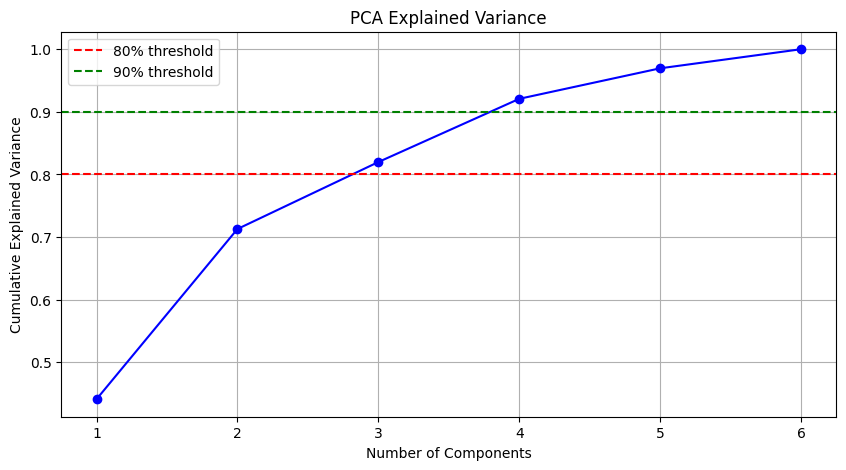

Variance explained by each component:
PC1: 0.441 (0.441 cumulative)
PC2: 0.272 (0.713 cumulative)
PC3: 0.107 (0.820 cumulative)
PC4: 0.101 (0.921 cumulative)
PC5: 0.049 (0.970 cumulative)
PC6: 0.030 (1.000 cumulative)


In [79]:
# Fit PCA with all components first

pca_full = PCA()
pca_full.fit(X_scaled)

# Plot cumulative variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, 7), pca_full.explained_variance_ratio_.cumsum(), 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% threshold')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% threshold')
plt.legend()
plt.grid()
plt.show()

print("Variance explained by each component:")
for i, var in enumerate(pca_full.explained_variance_ratio_, 1):
    print(f"PC{i}: {var:.3f} ({pca_full.explained_variance_ratio_[:i].sum():.3f} cumulative)")

**Analysis:**

The first 3 principal components capture 82.0% of the total variance in the data, exceeding the commonly used 80% threshold for dimensionality reduction. While adding a fourth component would increase cumulative variance to 92.1%, the marginal gain (10.1%) does not justify the added complexity. Therefore, n_components=3 was selected for clustering analysis, balancing information retention with model simplicity.

## Elbow (Inertia) + Silhouette Charts
### Identifying Number of Clusters
The elbow plot is used to identify the point at which adding more clusters results in diminishing reductions in inertia.
### The silhouette score measures how similar a point is to its own cluster compared to other clusters. The higher values indicate better-defined clusters.

In [80]:
# Apply PCA with chosen n_components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Range 2 to 10
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
  km = KMeans(n_clusters=k, random_state=42, n_init=10)
  labels = km.fit_predict(X_pca)

  inertias.append(km.inertia_)
  silhouette_scores.append(silhouette_score(X_pca, labels))

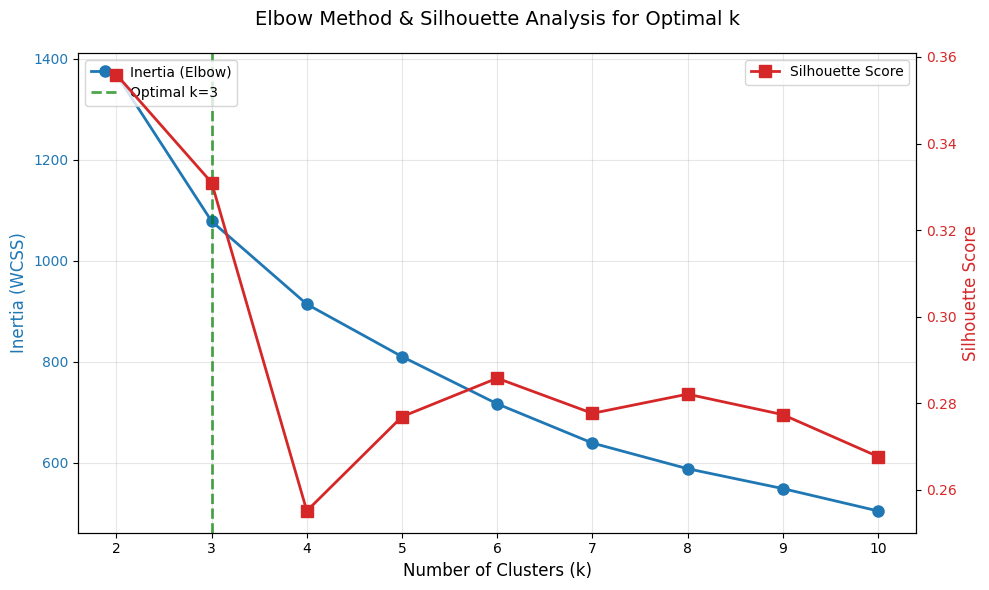


Cluster Evaluation:
k=2: Inertia=1368, Silhouette=0.356
k=3: Inertia=1078, Silhouette=0.331
k=4: Inertia=914, Silhouette=0.255
k=5: Inertia=810, Silhouette=0.277
k=6: Inertia=717, Silhouette=0.286
k=7: Inertia=639, Silhouette=0.278
k=8: Inertia=589, Silhouette=0.282
k=9: Inertia=549, Silhouette=0.277
k=10: Inertia=505, Silhouette=0.268


In [81]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Test k from 2 to 10
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)

    inertias.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, labels))

# Create overlapping plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot inertia on left y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (WCSS)', color=color1, fontsize=12)
ax1.plot(K_range, inertias, 'o-', color=color1, linewidth=2,
         markersize=8, label='Inertia (Elbow)')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(alpha=0.3)

# Create second y-axis for silhouette
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color2, fontsize=12)
ax2.plot(K_range, silhouette_scores, 's-', color=color2, linewidth=2,
         markersize=8, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color2)

# Add optimal k line
optimal_k = 3
ax1.axvline(x=optimal_k, color='green', linestyle='--',
            linewidth=2, alpha=0.7, label=f'Optimal k={optimal_k}')

# Title and legends
plt.title('Elbow Method & Silhouette Analysis for Optimal k', fontsize=14, pad=20)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print scores
print("\nCluster Evaluation:")
for k, inertia, sil in zip(K_range, inertias, silhouette_scores):
    print(f"k={k}: Inertia={inertia:.0f}, Silhouette={sil:.3f}")

**Interpretation:**

* Silhouette analysis (red) peaks at **k = 3** with an average score of 0.33, indicating acceptable separation for behavioral data. The elbow curve (blue) also shows diminishing returns beyond k = 3, suggesting no substantial improvement from additional clusters.
* Both silhouette and inertia merge at **k = 3**, indicating the three-cluster solution provides a better balance between separation and interpretability.


# Hierarchical clustering on desired PCA number of components

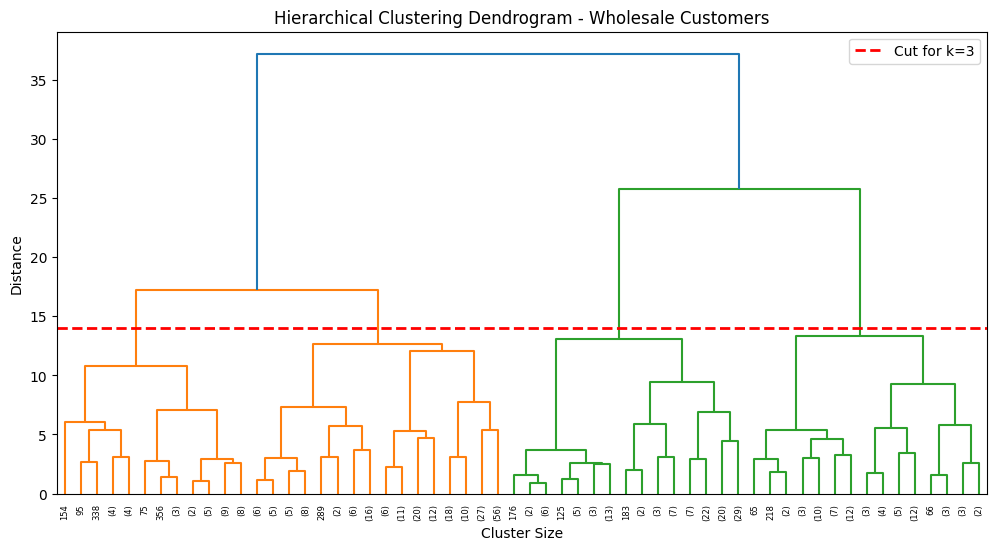

In [82]:
hac = linkage(X_pca, method='ward')

#Find clusters
clusters_hac = fcluster(hac, t=3, criterion='maxclust') # Force 3 clusters

plt.figure(figsize=(12,6))

dendro = dendrogram(hac, truncate_mode='level', p=5)
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram - Wholesale Customers')
plt.axhline(y=14, color='red', linestyle='--',
            linewidth=2, label='Cut for k=3')
plt.legend()
plt.show();

The dendrogram displays a clear separation at higher linkage distances, with a gap around a distance of 14. Splitting the dendrogram here at y=14 results in three main branches, which  is consistent with the three-cluster solution assessed by elbow and silhouette methods.

Therefore, k = 3 is selected as the optimal number of customer segments.